# Eruption Products Mapping

Goal: Use publically available satellite imagery from landsat 8 to map volcanic eruption products.

## Import Packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import datetime as dt
import xarray as xr
import rasterio
import pyproj
from sklearn.decomposition.pca import PCA

## Specify Dates and Locations of Volcanic Eruptions

See https://www.ngdc.noaa.gov/hazard/volcano.shtml 
and https://volcano.si.edu/search_volcano.cfm
for a list of historical eruptions. 

In [2]:
#example provided for fuego, guatemala
lat  = 14.473
lon  = -90.88
date = dt.date(year=2015,month=7,day=10)

In [3]:
#Read in file containing latitude-longitude information for LandSat 8 scenes
WRS = pd.read_csv('WRScornerPoints.csv')

In [4]:
#identify path and row of scenes containing specified latitude and longitude
#ascending scenes are taken at night, descending scenes during day
scene_asc = WRS.loc[(lat-WRS['LL LAT'] <= (WRS['UL LAT']-WRS['LL LAT'])/(WRS['UL LON']-WRS['LL LON'])*(lon-WRS['LL LON'])) &
        (lat-WRS['UR LAT'] >= (WRS['UL LAT']-WRS['UR LAT'])/(WRS['UL LON']-WRS['UR LON'])*(lon-WRS['UR LON'])) &
        (lat-WRS['LR LAT'] >= (WRS['UR LAT']-WRS['LR LAT'])/(WRS['UR LON']-WRS['LR LON'])*(lon-WRS['LR LON'])) &
        (lat-WRS['LR LAT'] <= (WRS['LL LAT']-WRS['LR LAT'])/(WRS['LL LON']-WRS['LR LON'])*(lon-WRS['LR LON'])) 
       ]

scene_dsc = WRS.loc[(lat-WRS['UL LAT'] <= (WRS['LL LAT']-WRS['UL LAT'])/(WRS['LL LON']-WRS['UL LON'])*(lon-WRS['UL LON'])) &
        (lat-WRS['LR LAT'] >= (WRS['LL LAT']-WRS['LR LAT'])/(WRS['LL LON']-WRS['LR LON'])*(lon-WRS['LR LON'])) &
        (lat-WRS['UR LAT'] >= (WRS['LR LAT']-WRS['UR LAT'])/(WRS['LR LON']-WRS['UR LON'])*(lon-WRS['UR LON'])) &
        (lat-WRS['UR LAT'] <= (WRS['UL LAT']-WRS['UR LAT'])/(WRS['UL LON']-WRS['UR LON'])*(lon-WRS['UR LON'])) 
       ]

PATH = []
ROW = []

#record all path,row pairs in descending orbits
for ind in scene_dsc.index:
    PATH = np.append(PATH, scene_dsc.loc[ind].PATH)
    ROW = np.append(ROW, scene_dsc.loc[ind].ROW)
    print(f'PATH {scene_dsc.loc[ind].PATH:1.0f}' + ',' + f'ROW  {scene_dsc.loc[ind].ROW:1.0f}')

scene_dsc

PATH 20,ROW  50


,PATH,ROW,CTR LAT,CTR LON,UL LAT,UL LON,UR LAT,UR LON,LL LAT,LL LON,LR LAT,LR LON
4762,20.0,50.0,14.456913,-90.841979,15.39,-91.543,15.134,-89.783,13.776,-91.895,13.522,-90.147


Text(0.5, 1.0, 'Scenes including coordinates')

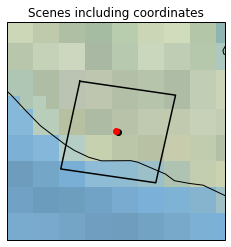

In [ ]:
#Plot scene boundaries on simple map
map_proj  = ccrs.PlateCarree(central_longitude=180)
data_proj = ccrs.PlateCarree()

fig,ax = plt.subplots(subplot_kw={'projection': map_proj})

ax.stock_img()
ax.coastlines('50m')
ax.plot(lon,lat,color='r',marker='o',transform=data_proj)
ax.scatter(scene_dsc['CTR LON'],scene_dsc['CTR LAT'],c='k',transform=data_proj)

for ind in scene_dsc.index:
    scene = scene_dsc.loc[ind]
    ax.plot([scene['UL LON'],scene['LL LON'],scene['LR LON'],scene['UR LON'],scene['UL LON']],
            [scene['UL LAT'],scene['LL LAT'],scene['LR LAT'],scene['UR LAT'],scene['UL LAT']],
            c='k',transform=data_proj)
    
ax.set_extent([lon-2, lon+2, lat-2, lat+2])
ax.set_title('Scenes including coordinates')

In [ ]:
#access online list of available scenes
scene_list = pd.read_csv('https://landsat-pds.s3.amazonaws.com/c1/L8/scene_list.gz')

In [ ]:
#convert acquisitionDate variable to datetime objects
scene_list['acquisitionDate'] = pd.to_datetime(scene_list.acquisitionDate)

In [ ]:
#identify scenes before and after eruption with low cloud cover
deltat = dt.timedelta(weeks=20)
fls_pre = pd.DataFrame()
for ind in scene_dsc.index:
    fls_pre = fls_pre.append(scene_list.loc[(scene_list['path']==scene_dsc.loc[ind].PATH) & (scene_list['row']==scene_dsc.loc[ind].ROW) &
                     (scene_list['acquisitionDate']>(date-deltat)) & (scene_list['acquisitionDate']<date) &
                     (scene_list['cloudCover'] <= 60)])
fls_pre = fls_pre.sort_values(by=['cloudCover'])
    
fls_post = pd.DataFrame()
for ind in scene_dsc.index:
    fls_post = fls_post.append(scene_list.loc[(scene_list['path']==scene_dsc.loc[ind].PATH) & (scene_list['row']==scene_dsc.loc[ind].ROW) &
                     (scene_list['acquisitionDate']>(date)) & (scene_list['acquisitionDate']<date+deltat) &
                     (scene_list['cloudCover'] <= 60)])
fls_post = fls_post.sort_values(by=['cloudCover'])
fls_post

C:\Users\Janine\Anaconda3\envs\RCES_Final\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  
C:\Users\Janine\Anaconda3\envs\RCES_Final\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  del sys.path[0]


,productId,entityId,acquisitionDate,cloudCover,processingLevel,path,row,min_lat,min_lon,max_lat,max_lon,download_url
906327,LC08_L1TP_020050_20150804_20170226_01_T1,LC80200502015216LGN01,2015-08-04 16:23:44.672992,4.80,L1TP,20,50,13.39582,-91.85744,15.50486,-89.76694,https://s3-us-west-2.amazonaws.com/landsat-pds...
906326,LC08_L1TP_020050_20150719_20170226_01_T1,LC80200502015200LGN01,2015-07-19 16:23:41.866244,8.52,L1TP,20,50,13.39607,-91.87683,15.50496,-89.78631,https://s3-us-west-2.amazonaws.com/landsat-pds...
906328,LC08_L1TP_020050_20150820_20170225_01_T1,LC80200502015232LGN01,2015-08-20 16:23:52.564642,9.96,L1TP,20,50,13.39590,-91.86298,15.50489,-89.77248,https://s3-us-west-2.amazonaws.com/landsat-pds...
906331,LC08_L1TP_020050_20151007_20170225_01_T1,LC80200502015280LGN01,2015-10-07 16:24:08.486096,13.14,L1TP,20,50,13.39597,-91.86852,15.50492,-89.77801,https://s3-us-west-2.amazonaws.com/landsat-pds...
906332,LC08_L1TP_020050_20151023_20180130_01_T1,LC80200502015296LGN02,2015-10-23 16:24:11.894355,15.44,L1TP,20,50,13.39600,-91.87129,15.50493,-89.78078,https://s3-us-west-2.amazonaws.com/landsat-pds...
906329,LC08_L1TP_020050_20150905_20170225_01_T1,LC80200502015248LGN01,2015-09-05 16:23:57.661124,25.65,L1TP,20,50,13.39586,-91.86021,15.50488,-89.76971,https://s3-us-west-2.amazonaws.com/landsat-pds...
906333,LC08_L1TP_020050_20151108_20170225_01_T1,LC80200502015312LGN01,2015-11-08 16:24:14.070396,27.05,L1TP,20,50,13.39600,-91.87129,15.50493,-89.78078,https://s3-us-west-2.amazonaws.com/landsat-pds...
906334,LC08_L1TP_020050_20151124_20170225_01_T1,LC80200502015328LGN01,2015-11-24 16:24:16.497955,40.94,L1TP,20,50,13.39607,-91.87683,15.50496,-89.78631,https://s3-us-west-2.amazonaws.com/landsat-pds...
906330,LC08_L1TP_020050_20150921_20170302_01_T1,LC80200502015264LGN02,2015-09-21 16:24:05.974147,59.53,L1TP,20,50,13.39604,-91.87406,15.50495,-89.78354,https://s3-us-west-2.amazonaws.com/landsat-pds...


## Find Data on Amazon S3

In [ ]:
#define dictionary specifying bands of interest
bands = {'B2': 'BLUE','B3': 'GREEN','B4': 'RED','B5': 'NIR','B7': 'SWIR','B10': 'THERM'}

In [ ]:
#download the first band to get geometric data
#for raster images all bands must have same geometric information

def downloadGeom(fls,scene_num):
    fls.download_url.iloc[scene_num]
    url = fls.download_url.iloc[-1][:-10] + fls.productId.iloc[-1] + '_B10.TIF'
    #url = fls.download_url.iloc[scene_num][:-10] + fls.entityId.iloc[scene_num] + '_B2.TIF'
    BLUE = rasterio.open(url)
    return(BLUE)

In [ ]:
scene_pre = 0
scene_post = 0

BLUE_pre = downloadGeom(fls_pre,scene_pre)
BLUE_post = downloadGeom(fls_post,scene_post)
BLUE_pre

<open RasterReader name='https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/020/050/LC08_L1TP_020050_20150516_20170301_01_T1/LC08_L1TP_020050_20150516_20170301_01_T1_B10.TIF' mode='r'>

In [ ]:
def projInfo(BLUE,lat,lon):
    #define data projection from metadata
    dataProj = pyproj.Proj(BLUE.crs) # Pass CRS of image from rasterio
    lonlatProj = pyproj.Proj(init='epsg:4326')

    #find volcanic center in data coordinates (UTM)
    east,north = pyproj.transform(lonlatProj, dataProj, lon, lat)

    #define dimension coordinates
    x = np.linspace(BLUE.bounds.left,BLUE.bounds.right,BLUE.width,endpoint=True)
    y = np.linspace(BLUE.bounds.top,BLUE.bounds.bottom,BLUE.height,endpoint=True)

    #initialize dataset using first band
    ds = xr.Dataset(data_vars={'BLUE': (('y','x'), BLUE.read(1))}, coords={'x': x, 'y': y})
    
    return(east,north,ds)

In [ ]:
east_pre, north_pre, ds_pre = projInfo(BLUE_pre,lat,lon)
east_post, north_post, ds_post = projInfo(BLUE_post,lat,lon)
ds_post

<xarray.Dataset>
Dimensions:  (x: 7551, y: 7711)
Coordinates:
  * x        (x) float64 6.219e+05 6.219e+05 6.219e+05 ... 8.484e+05 8.484e+05
  * y        (y) float64 1.715e+06 1.714e+06 1.714e+06 ... 1.483e+06 1.483e+06
Data variables:
    BLUE     (y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0

In [ ]:
#loop through bands, adding each to the dataset
def downloadBands(fls,scene_num,bands,ds):
    for key in bands.keys():
        url = fls.download_url.iloc[-1][:-10] + fls.productId.iloc[-1] + '_' + key + '.TIF'
        ds[bands[key]] = (('y','x'),rasterio.open(url).read(1))
    return(ds)

In [ ]:
ds_pre = downloadBands(fls_pre,scene_pre,bands,ds_pre)
ds_post = downloadBands(fls_post,scene_post,bands,ds_post)
ds_pre

In [ ]:
#define function to normalize values in each band to maximize dynamic range in images
#convert to uint8 (LandSat8 comes as uint16)
def normalize(reflect):
    reflect -= reflect.min()
    reflect = reflect - reflect.where(reflect>0).min()
    reflect = reflect - reflect.where(reflect<0,0)
    reflect = reflect/reflect.max()*255
    reflect = np.array(reflect, np.uint8)
    return reflect

In [ ]:
#zoom in on region of interest
def zoomIn(ds,east,north,bands,margin):
    zoom = ds.sel(x=slice(east-margin, east+margin), y=slice(north+margin, north-margin))

    for key in bands.keys():
        zoom[bands[key]]  = (('y','x'),normalize(zoom[bands[key]]))
    extent = [zoom.x.min(), zoom.x.max(), zoom.y.min(), zoom.y.max()]
    
    #display data as images
    #natural color composite
    fig,ax = plt.subplots(figsize=(12,8))
    ax.imshow(np.dstack((zoom.RED,zoom.GREEN,zoom.BLUE)),
              origin='upper', extent=extent)
    ax.scatter(east,north)
    ax.set_title('Natural Color Composite')

    #false color composite
    fig2,ax2 = plt.subplots(figsize=(12,8))
    ax2.imshow(np.dstack((zoom.GREEN,zoom.NIR,zoom.SWIR)),
               origin='upper', extent=extent)
    ax2.set_title('False Color Composite')

    #thermal
    fig3,ax3 = plt.subplots(figsize=(12,8))
    ax3.imshow(zoom.THERM, cmap='Greys_r',
               origin='upper', extent=extent)
    ax3.set_title('Thermal')
    return(zoom,extent)

In [ ]:
margin = 2000

%matplotlib inline
zoom_pre, extent_pre = zoomIn(ds_pre, east_pre, north_pre, bands, margin)
zoom_post, extent_post = zoomIn(ds_post, east_post, north_post, bands, margin)

## Principal Component Analysis

In [ ]:
# Principal Component Analysis
def PCFlat(zoom):
    flat = [];
    for key in bands.keys():
        flat.append(zoom[bands[key]].values.flatten())
    return(flat)

flat_pre = PCFlat(zoom_pre)
flat_post = PCFlat(zoom_post)

pca = PCA(n_components=6)
pca.fit(np.transpose(flat_pre))

fig,ax = plt.subplots()
ax.plot(pca.singular_values_)
ax.set_title('Principal Component Singular Values')

fig,ax = plt.subplots()
for i in np.arange(6):
    ax.plot(pca.components_[i])
ax.legend(['PC1','PC2','PC3','PC4','PC5','PC6'],loc='lower right')
locs, labels = plt.xticks()
plt.xticks(np.arange(6), bands.values())
ax.set_title('Principal Components')


In [ ]:
def PCTrans(pca,flat,zoom):
    trans = pca.transform(np.transpose(flat))
    PC = xr.Dataset(data_vars={'PC1':(('y','x'),
                               trans[:,0].reshape(zoom.BLUE.shape))},
                    coords={'x': zoom.BLUE.x, 
                            'y': zoom.BLUE.y})
    for i in np.arange(1,6):
        PC['PC'+np.array2string(i+1)] = (('y','x'),trans[:,i].reshape(zoom.BLUE.shape))
    return(PC)

In [ ]:
PC_pre  = PCTrans(pca,flat_pre,zoom_pre)
PC_post = PCTrans(pca,flat_post,zoom_post)
PC_post

In [ ]:
# PC with highest component in SWIR
# PCnum = np.argmax(pca.components_[:,4])

# Or specify PC
PCnum = np.array(4)

PCname = 'PC'+np.array2string(PCnum+1)

fig,ax = plt.subplots(figsize=(12,8), ncols=2)
ax[0].imshow(PC_pre[PCname],origin='upper', extent=extent_pre)
ax[0].set_title('Pre-eruptive')
ax[1].imshow(PC_post[PCname],origin='upper', extent=extent_post)
ax[1].set_title('Post-eruptive')

PCname

In [ ]:
#if (np.round(extent_pre) == np.round(extent_post)).all():
PCChange = PC_post - PC_pre
    
fig,ax = plt.subplots(figsize=(12,8))
im = ax.imshow(PCChange[PCname],origin='upper', extent=extent_pre, cmap='bwr', vmax=100, vmin=-100)
plt.colorbar(im)
ax.set_title('Ground Cover Change in high-SWIR Principal Component')

In [ ]:
threshold = 80 # modify to isolate desired region

(PCChange[PCname]>threshold).plot()
print(np.array2string((PCChange[PCname]>50).sum()*0.03**2) + ' km^2 Covered')
ax.set_title('Eruption Products')